In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, r2_score

import tensorflow as tf


In [2]:
positive_dir = Path(r'C:\Users\aditi\Downloads\UG 2\UG_crack_detection\data\Positive')
negative_dir = Path(r'C:\Users\aditi\Downloads\UG 2\UG_crack_detection\data\Negative')

In [3]:
def generate_df(img_dir, label):
    
    file_paths = pd.Series(list(img_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=file_paths.index)
    df = pd.concat([file_paths, labels], axis=1)
    
    return df

In [4]:
positive_df = generate_df(positive_dir, 'POSITIVE')
negative_df = generate_df(negative_dir, 'NEGATIVE')

# concatenate both positive and negative df
all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1, random_state=1).reset_index(drop=True)
all_df

,Filepath,Label
0,C:\Users\aditi\Downloads\UG 2\UG_crack_detecti...,POSITIVE
1,C:\Users\aditi\Downloads\UG 2\UG_crack_detecti...,POSITIVE
2,C:\Users\aditi\Downloads\UG 2\UG_crack_detecti...,POSITIVE
3,C:\Users\aditi\Downloads\UG 2\UG_crack_detecti...,NEGATIVE
4,C:\Users\aditi\Downloads\UG 2\UG_crack_detecti...,POSITIVE
...,...,...
39995,C:\Users\aditi\Downloads\UG 2\UG_crack_detecti...,POSITIVE
39996,C:\Users\aditi\Downloads\UG 2\UG_crack_detecti...,NEGATIVE
39997,C:\Users\aditi\Downloads\UG 2\UG_crack_detecti...,POSITIVE
39998,C:\Users\aditi\Downloads\UG 2\UG_crack_detecti...,POSITIVE


In [5]:
train_df, test_df = train_test_split(all_df.sample(6000, random_state=1), 
                train_size=0.8,
                shuffle=True,
                random_state=1)

In [6]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, # type: ignore
                                                           validation_split=0.2)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [7]:
train_data = train_gen.flow_from_dataframe(train_df, 
                                          x_col='Filepath',
                                          y_col='Label',
                                          target_size=(120,120), 
                                          color_mode='rgb',
                                          class_mode='binary',
                                          batch_size=32,
                                          shuffle=True,
                                          seed=42,
                                          subset='training')


val_data = train_gen.flow_from_dataframe(train_df, 
                                          x_col='Filepath',
                                          y_col='Label',
                                          target_size=(120,120), 
                                          color_mode='rgb',
                                          class_mode='binary',
                                          batch_size=32,
                                          shuffle=True,
                                          seed=42,
                                          subset='validation')
test_data = test_gen.flow_from_dataframe(test_df, 
                                          x_col='Filepath',
                                          y_col='Label',
                                          target_size=(120,120), 
                                          color_mode='rgb',
                                          class_mode='binary',
                                          batch_size=32,
                                          shuffle=False,
                                          seed=42)

Found 3840 validated image filenames belonging to 2 classes.
Found 960 validated image filenames belonging to 2 classes.
Found 1200 validated image filenames belonging to 2 classes.


In [8]:
test_data

In [9]:
inputs = tf.keras.Input(shape=(120,120,3)) # type: ignore
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(inputs) # type: ignore
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [10]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [11]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [12]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 118, 118, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,121 (20.00 KB)

 Trainable params: 5,121 (20.00 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(train_data, validation_data=val_data, epochs=100, 
                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                              patience=3,
                                                              restore_best_weights=True)
                             ])

Epoch 1/100


C:\Users\aditi\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


120/120 ━━━━━━━━━━━━━━━━━━━━ 57s 436ms/step - accuracy: 0.5515 - loss: 0.6843 - val_accuracy: 0.7333 - val_loss: 0.6510
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.6652 - loss: 0.6340 - val_accuracy: 0.5510 - val_loss: 0.6662
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.7571 - loss: 0.5564 - val_accuracy: 0.8469 - val_loss: 0.4731
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.8727 - loss: 0.4365 - val_accuracy: 0.9198 - val_loss: 0.3195
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.9202 - loss: 0.3187 - val_accuracy: 0.9427 - val_loss: 0.2501
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - accuracy: 0.9464 - loss: 0.2429 - val_accuracy: 0.9479 - val_loss: 0.2013
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.9512 - loss: 0.1991 - val_accuracy: 0.9469 - val_loss: 0.1700
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.9565 - loss: 0.1783 - val

In [15]:
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    accuracy = results[1]
    
    print(f'Test Loss {loss:.5f}')
    print(f'Test Accuracy {accuracy * 100:.2f} %')
    
    
    # predicted y values
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(int))
    y_certain = np.squeeze((model.predict(test_data)).astype(int))
    
    conf_matr = confusion_matrix(test_data.labels, y_pred)
    
    class_report = classification_report(test_data.labels, y_pred,
                                         target_names=['NEGATIVE', 'POSITIVE'])
    
    plt.figure(figsize=(6,6))
    
    sns.heatmap(conf_matr, fmt='g', annot=True, cbar=False, vmin=0, cmap='Blues')
    
    plt.xticks(ticks=np.arange(2) + 0.5, labels=['NEGATIVE', 'POSITIVE'])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=['NEGATIVE', 'POSITIVE'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    print('r2 Score : ', r2_score(test_data.labels, y_pred))
    print()
    print('Classification Report :\n......................\n', class_report)

Test Loss 0.07892
Test Accuracy 97.92 %
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step


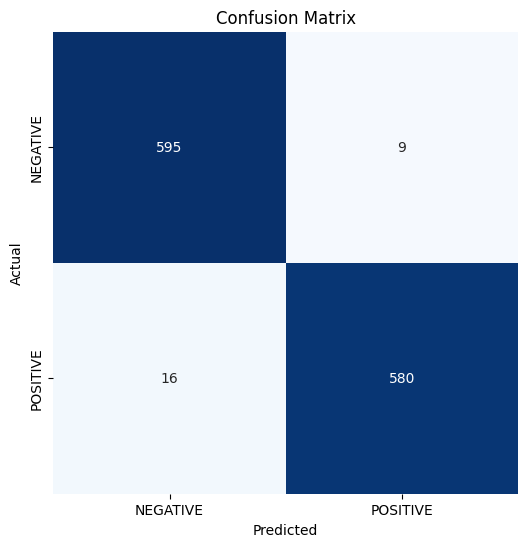

r2 Score :  0.9166629627983466

Classification Report :
......................
               precision    recall  f1-score   support

    NEGATIVE       0.97      0.99      0.98       604
    POSITIVE       0.98      0.97      0.98       596

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200



In [16]:
evaluate_model(model, test_data)


In [17]:
from pathlib import Path
import pandas as pd
import numpy as np

def test_new_data(dir_path, image_column_name='Filepath'):
    
    new_test_dir = Path(dir_path)
    
    df_new = generate_df(new_test_dir, 'Testing')
    
    test_data_new = test_gen.flow_from_dataframe(df_new, 
                                                 x_col=image_column_name,  # Assuming the column containing file paths
                                                 y_col='Label',
                                                 target_size=(120,120), 
                                                 color_mode='rgb',
                                                 batch_size=5,
                                                 shuffle=False,
                                                 seed=42)
    
    # Predicted y values
    y_pred = np.squeeze((model.predict(test_data_new) >= 0.5).astype(int))
    
    y_certain = model.predict(test_data_new).round(6)
    
    y_out = []
    for i in y_pred:
        if i == 0:
            y_out.append('Negative (Not Crack)')
        else:
            y_out.append('Positive (Crack)')
            
    # Extract image addresses
    image_addresses = df_new[image_column_name].tolist()
    
    result = pd.DataFrame(np.c_[image_addresses, y_out, y_certain], 
                          columns=['Image_Address', 'Result', 'Confidence of being Cracked'])
    
    return result


In [18]:
test_new_data(r'C:\Users\aditi\Downloads\UG 2\UG_crack_detection\sampledata')

Found 500 validated image filenames belonging to 1 classes.
  3/100 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step  

C:\Users\aditi\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


,Image_Address,Result,Confidence of being Cracked
0,C:\Users\aditi\Downloads\UG 2\UG_crack_detecti...,Positive (Crack),0.948206
1,C:\Users\aditi\Downloads\UG 2\UG_crack_detecti...,Negative (Not Crack),0.294302
2,C:\Users\aditi\Downloads\UG 2\UG_crack_detecti...,Positive (Crack),0.947966
3,C:\Users\aditi\Downloads\UG 2\UG_crack_detecti...,Positive (Crack),0.818226
4,C:\Users\aditi\Downloads\UG 2\UG_crack_detecti...,Negative (Not Crack),0.260267
...,...,...,...
495,C:\Users\aditi\Downloads\UG 2\UG_crack_detecti...,Negative (Not Crack),0.02296
496,C:\Users\aditi\Downloads\UG 2\UG_crack_detecti...,Negative (Not Crack),0.084104
497,C:\Users\aditi\Downloads\UG 2\UG_crack_detecti...,Negative (Not Crack),0.021572
498,C:\Users\aditi\Downloads\UG 2\UG_crack_detecti...,Negative (Not Crack),0.050785


In [20]:
import json

def convert_to_json(predictions_df):
    # Convert DataFrame to JSON
    json_output = predictions_df.to_json(orient='records')
    return json_output

# Get predictions for new data
predictions_df = test_new_data(r'C:\Users\aditi\Downloads\UG 2\UG_crack_detection\sampledata')

# Convert predictions to JSON
json_output = convert_to_json(predictions_df)

# Write JSON to a file
with open('predictions.json', 'w') as json_file:
    json_file.write(json_output)

Found 500 validated image filenames belonging to 1 classes.
 18/100 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

C:\Users\aditi\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
